<a href="https://colab.research.google.com/github/guillermodulcey/TesisCinvestav/blob/main/MSR/ValidacionModelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
seed = 123

In [ ]:
from scipy.spatial import distance

class SOM():
  def __init__(self, m, n, inputs, seed=123):
    self.m = m
    self.n = n
    self.dim = inputs.shape[1]
    self.std_coeff = 0.5

    self.initial_learning_rate = 0.1
    self.initial_radius = np.max((self.m, self.n)) / 2
    self.inputs = inputs
    self.w_init = tf.random_uniform_initializer(maxval=1, seed=seed)
    self.weights = tf.Variable(initial_value=self.w_init(shape=[self.m * self.n, self.dim], dtype="float32"), name='weights')
    self.location_vects = tf.constant(np.array(list(self.neuron_locations())), name='Location_Vectors')

  def neuron_locations(self):
    for i in range(self.m):
      for j in range(self.n):
          yield np.array([i, j])

  def train(self, max_epochs):
    tf_inputs = tf.Variable(self.inputs)
    for epoch in range(1, max_epochs+1):
      mean = tf.reduce_mean(self.weights)
      std = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.weights, mean)))
      max = tf.reduce_max(self.weights)
      min = tf.reduce_min(self.weights)

      squared_distance = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.weights, axis=0),tf.expand_dims(tf_inputs, axis=1)), 2), 2)
      # BMU_Indices (Best matching unit)
      bmu_indices = tf.argmin(squared_distance, axis=1)
      # BMU_Locations
      bmu_locs = tf.reshape(tf.gather(self.location_vects, bmu_indices), [-1, 2])
      # Learning_Rate
      radius = tf.subtract(self.initial_radius, tf.multiply(epoch, tf.divide(tf.cast(tf.subtract(self.initial_radius, 1), tf.float32),
                                            tf.cast(tf.subtract(max_epochs+1, 1), tf.float32))))
      alpha = tf.multiply(self.initial_learning_rate, tf.subtract(1.0, tf.divide(tf.cast(epoch, tf.float32),
                                                  tf.cast(max_epochs+1, tf.float32))))
      bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.location_vects, axis=0),
                                                  tf.expand_dims(bmu_locs, axis=1)), 2), 2)
      neighbourhood_func = tf.exp(tf.divide(tf.negative(tf.cast(bmu_distance_squares, "float32")), tf.multiply(
                                                        tf.square(tf.multiply(radius, self.std_coeff)), 2)))
      learning_rate_op = tf.multiply(neighbourhood_func, alpha)
      # Update_Weights
      numerators = tf.reduce_sum(tf.multiply(tf.expand_dims(learning_rate_op, axis=-1), tf.expand_dims(tf_inputs, axis=1)), axis=0)
      denominators = tf.expand_dims(tf.reduce_sum(learning_rate_op, axis=0) + float(1e-12), axis=-1)
        
      self.weights = tf.divide(numerators, denominators)
    return self.weights

  def transform(self):
    result_matrix = list()
    for i, row in enumerate(self.inputs):
      image_document = np.zeros(shape=self.m*self.n, dtype=np.float32)
      for j, node in enumerate(self.weights.numpy()):
        #image_document[j]=np.dot(row, node.weights)
        image_document[j] = 1.0/distance.euclidean(row, node)
      mn = image_document.min()
      mx = image_document.max()
      image_document = ((image_document-mn)/(mx-mn)*255.9).astype(np.uint8)
      image_document = image_document.reshape(self.m, self.n)
      result_matrix.append(image_document)

    return np.array(result_matrix)

  def save(self, name):
    np.save(f'drive/MyDrive/Models/{name}.npy', self.weights)

  def load(self, name):
    self.weights = np.load(f'drive/MyDrive/Models/{name}.npy')
    self.weights = tf.Variable(self.weights)

In [ ]:
class DatasetAlignment():
  def __init__(self, size=3000, val_size=2000, seed=123):
    text_dataset = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=seed,
      validation_split=.2,
      subset='training',
      follow_links=False,
    )

    text_validation = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=seed,
      validation_split=.2,
      subset='validation',
      follow_links=False,
    )

    (colorectal_dataset, colorectal_validation), colorectal_info = tfds.load('colorectal_histology', 
                                                      split=[f'train[:{size}]', f'train[{size}:]'], 
                                                      shuffle_files=False, 
                                                      with_info=True, 
                                                      as_supervised=True)

    self.cats_dogs = colorectal_dataset.take(size)
    self.reviews = text_dataset.take(size)

    self.validation_cats_dogs = colorectal_validation.take(val_size)
    self.validation_reviews = text_validation.take(val_size)

  def train_text(self, max_words=10000):
    for texts, t_labels in self.reviews.take(1):  # only take first batch of dataset
      numpy_text = texts.numpy()
      numpy_t_labels = t_labels.numpy()

    train = pd.DataFrame()
    train['text'] = pd.Series(numpy_text)
    train['label'] = pd.Series(numpy_t_labels)

    train_labels = train['label']
    train_text = train['text']

    train_text = train_text.apply(lambda x: x.decode('utf-8'))

    self.tokenizer = Tokenizer(max_words, oov_token='<OOV>')

    self.tokenizer.fit_on_texts(train_text.to_list())
    self.total_words = len(self.tokenizer.word_index)+1

    train_sequences = self.tokenizer.texts_to_sequences(train_text.to_list())
    train_padded = pad_sequences(train_sequences)

    train_labels = np.array(train_labels.to_list())

    self.max_sequence_length = train_padded.shape[1]

    self.reviews = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))

    ## Validation
    for texts, t_labels in self.validation_reviews.take(1):  # only take first batch of dataset
      validation_text = texts.numpy()
      validation_labels = t_labels.numpy()

    validation = pd.DataFrame()
    validation['text'] = pd.Series(validation_text)
    validation['label'] = pd.Series(validation_labels)

    validation_labels = validation['label']

    validation_text = validation['text']
    validation_text = validation_text.apply(lambda x: x.decode('utf-8'))

    validation_sequences = self.tokenizer.texts_to_sequences(validation_text.to_list())
    validation_padded = pad_sequences(validation_sequences, maxlen=self.max_sequence_length)

    validation_labels = np.array(validation_labels.to_list())

    self.validation_reviews = tf.data.Dataset.from_tensor_slices((validation_padded, validation_labels))

  def align(self):
    one_i = self.cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.cats_dogs.filter(lambda x,y: y == 1)
    
    one_t = self.reviews.filter(lambda x,y: y == 0)
    two_t = self.reviews.filter(lambda x,y: y == 1)
    
    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.cats_dogs = merged.map(lambda x, y: x)
    self.reviews = merged.map(lambda x, y: y)

    return self.cats_dogs, self.reviews

  def validation(self, size=10000):
    one_i = self.validation_cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.validation_cats_dogs.filter(lambda x,y: y == 1)

    one_t = self.validation_reviews.filter(lambda x,y: y == 0)
    two_t = self.validation_reviews.filter(lambda x,y: y == 1)

    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.validation_cats_dogs = merged.map(lambda x, y: x)
    self.validation_reviews = merged.map(lambda x, y: y)

    return self.validation_cats_dogs, self.validation_reviews

  def reshuffle_text(self, size=3000, val_size=2000, seed=123):
    text_validation = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=seed,
      validation_split=.2,
      subset='validation',
      follow_links=False,
    )

    self.validation_reviews = text_validation.take(val_size)

    for texts, t_labels in self.validation_reviews.take(1):  # only take first batch of dataset
      validation_text = texts.numpy()
      validation_labels = t_labels.numpy()

    validation = pd.DataFrame()
    validation['text'] = pd.Series(validation_text)
    validation['label'] = pd.Series(validation_labels)

    validation_labels = validation['label']

    validation_text = validation['text']
    validation_text = validation_text.apply(lambda x: x.decode('utf-8'))

    validation_sequences = self.tokenizer.texts_to_sequences(validation_text.to_list())
    validation_padded = pad_sequences(validation_sequences, maxlen=self.max_sequence_length)

    validation_labels = np.array(validation_labels.to_list())

    self.validation_reviews = tf.data.Dataset.from_tensor_slices((validation_padded, validation_labels))


# Carga Modelos

In [ ]:
# Load models

image_model = tf.keras.models.load_model('drive/MyDrive/Models/image_model_som_med_b.tf')
text_model = tf.keras.models.load_model('drive/MyDrive/Models/text_model_som_med_b.tf')

spectral_model = tf.keras.models.load_model('drive/MyDrive/Models/spectral_model_som_med_b.tf')

# Compiler

# any_model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
da = DatasetAlignment(seed=seed)
da.train_text()
cats_dogs, reviews = da.align()

Found 1619 files belonging to 2 classes.
Using 1296 files for training.
Found 1619 files belonging to 2 classes.
Using 323 files for validation.


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteG3GP2C/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
total_words = da.total_words
max_sequence_length = da.max_sequence_length

In [ ]:
validation_cats_dogs, validation_reviews = da.validation()

In [ ]:
text_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
text_result = text_model.predict(validation_reviews.batch(32), verbose=1)

11/11 [==============================] - 8s 122ms/step


In [ ]:
image_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
IMAGE_RES = 299

resize_function = lambda x, y: (tf.image.resize(x, (IMAGE_RES, IMAGE_RES))/255.0, y)

validation_batches = validation_cats_dogs.map(resize_function).batch(32).prefetch(1)

In [ ]:
image_result = image_model.predict(validation_batches, verbose=1)

12/12 [==============================] - 30s 245ms/step


In [ ]:
grid = 10

som_text = SOM(grid,grid, text_result)
som_images = SOM(grid,grid, image_result)

som_text.load('som_text_tf_b')
som_images.load('som_image_tf_b')

In [ ]:
text_images_matrix = som_text.transform()
images_images_matrix = som_images.transform()

In [ ]:
spectral_images = []

for i, image in enumerate(images_images_matrix):
  r = image.flatten()
  g = text_images_matrix[i].flatten()
  b = np.zeros_like(r)
  spectral = list(zip(r, g, b))
  spectral_images.append(np.array(spectral).reshape(grid,grid,3))

In [ ]:
labels = validation_reviews.batch(32)

y = np.concatenate([y for x, y in labels], axis=0)

In [ ]:
spectral_data = tf.data.Dataset.from_tensor_slices((spectral_images, y))

In [ ]:
spectral_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
validation_spectral_batches = spectral_data.map(resize_function).batch(32).prefetch(1)

In [ ]:
spectral_model.evaluate(validation_spectral_batches)

11/11 [==============================] - 2s 109ms/step - loss: 0.2602 - accuracy: 0.9195


[0.26016318798065186, 0.9195046424865723]

tf.Tensor(0, shape=(), dtype=int64)


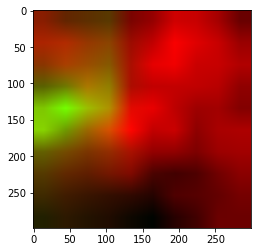

In [ ]:
for x, y in validation_spectral_batches:
  image = x
  label = y
  break

print(label[0])
plt.imshow(image[0])

tf.Tensor(1, shape=(), dtype=int64)


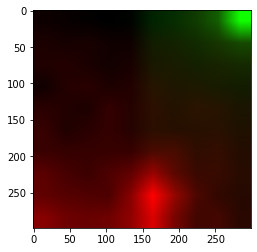

In [ ]:
image = None
label = None

for x, y in validation_spectral_batches:
  if y[0].numpy() == 1:
    image = x
    label = y
    break

print(label[0])
plt.imshow(image[0])

In [ ]:
spectral_result = spectral_model.predict(validation_spectral_batches, verbose=1)

11/11 [==============================] - 2s 114ms/step


In [ ]:
y_true = np.concatenate([y_t.numpy() for _ , y_t in validation_spectral_batches], axis=0)

In [ ]:
len(y_true)

323

In [ ]:
y_pred = [1 if y_t > 0.5 else 0 for y_t in spectral_result]

In [ ]:
from sklearn.metrics import classification_report

class_result = classification_report(y_true, y_pred)
print(class_result)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       105
           1       0.92      0.97      0.94       218

    accuracy                           0.92       323
   macro avg       0.92      0.89      0.91       323
weighted avg       0.92      0.92      0.92       323



In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix

array([[ 86,  19],
       [  7, 211]])

In [ ]:
import json

np.save(f'drive/MyDrive/Models/results/matrix_{seed}.npy', conf_matrix)

to_fi = json.dumps(class_result)
with open(f'drive/MyDrive/Models/results/classreport_{seed}', 'w') as file:
    file.write(to_fi)

In [ ]:
import os

print(len(os.listdir('drive/MyDrive/Models/results/'))-1)

100


In [ ]:
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import json

seed = 1490
grid = 10

for i in range(8):
  # tf.keras.backend.clear_session()
  seed = seed + random.randint(10, 50)
  da.reshuffle_text(seed=seed)
  validation_cats_dogs, validation_reviews = da.validation()
  text_result = text_model.predict(validation_reviews.batch(32), verbose=1)

  validation_batches = validation_cats_dogs.map(resize_function).batch(32).prefetch(1)
  image_result = image_model.predict(validation_batches, verbose=1)

  som_text = SOM(grid,grid, text_result)
  som_images = SOM(grid,grid, image_result)

  som_text.load('som_text_tf_b')
  som_images.load('som_image_tf_b')

  text_images_matrix = som_text.transform()
  images_images_matrix = som_images.transform()

  spectral_images = list()

  for i, image in enumerate(images_images_matrix):
    r = image.flatten()
    g = text_images_matrix[i].flatten()
    b = np.zeros_like(r)
    spectral = list(zip(r, g, b))
    spectral_images.append(np.array(spectral).reshape(grid,grid,3))

  labels = validation_reviews.batch(32)

  y = np.concatenate([y for x, y in labels], axis=0)

  spectral_data = tf.data.Dataset.from_tensor_slices((spectral_images, y))

  validation_spectral_batches = spectral_data.map(resize_function).batch(32).prefetch(1)

  spectral_result = spectral_model.predict(validation_spectral_batches, verbose=1)

  y_true = np.concatenate([y_t.numpy() for _ , y_t in validation_spectral_batches], axis=0)

  y_pred = [1 if y_t > 0.5 else 0 for y_t in spectral_result]

  class_result = classification_report(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  np.save(f'drive/MyDrive/Models/results/matrix_{seed}.npy', conf_matrix)

  to_fi = json.dumps(class_result)
  with open(f'drive/MyDrive/Models/results/classreport_{seed}', 'w') as file:
      file.write(to_fi)

Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 115ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 118ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 119ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 118ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 118ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 118ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [==============================] - 1s 117ms/step
Found 1619 files belonging to 2 classes.
Using 323 files for validation.
10/10 [========================